# Autocodificador sin reducción de dimensionalidad explicita

El siguiente autocodificador se creo bajo la idea de reducir la dimensionalidad para una  base de datos de alta dimensión, a diferencia de un autocodificador tradicional en el cual se van reduciendo el número de neuronas gradualmente a manera de "embudo" la arquitectura de esté autocodifacodr tiene un cambio pequeño pero significativo.

Cuando en un autocodificador clásico se llega a la representación latente más comprimida la dimensión de este vector latente es igual al número de neuronas del espacio latente, tipicamnete la dimensión latente es más pequeña que la dimensión de los datos de entrada así logrando reducir la dimensión de los datos, está representación latente se encuentra en la mitad de nuestro autocodificador y dependiendo del tipo de datos de entrada se seleccionan las funciones de costo, las cuales son normalmente una de regularización y de reconstrucción, ya que el objetivo al construir un autocodificador es lograr reproducir los datos de entrada.

En este autocodificador tenemos  un espacio latente de la misma dimensión que los datos de entrada, lo cual no tendría sentido ya que no se está reduciendo la dimensionalidad pero añadimos un término de regularización a la función de costo el cual es la norma L2 de el vector latente para de esta fortma lograr que la salida de algunas neuronas se acerque o se haga cero, de esta manera se lográ reducir la dimensionalidad de manera implicita ya que auqellas  neuronas que esten cerca del cero o sean cero, podemos considerarlas como si no estuvieran ahí (ya que no aportan información significativa a la representación latente) por lo que podemos "cortarlas", de esta manera reduciendo las dimensiones de la información de entrada.

In [1]:
import wandb
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

2026-02-09 20:24:22.419047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("GPUS disponibles", tf.config.list_physical_devices('GPU'))

GPUS disponibles [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = pd.read_csv('Liver_GSE14520_U133A.csv')
data.drop(['samples','type'], axis=1, inplace=True)
data.head()



,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,3.654116,3.804983,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,5.137159,8.622475,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,4.515175,12.681439,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,5.192624,11.759412,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,4.961625,10.318552,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


In [4]:
# Normalización de los datos
data = data.values.astype(np.float32)
data = StandardScaler().fit_transform(data)

In [5]:
input_dim = data.shape[1]
latent_dim = input_dim
run = wandb.init(project = "Experimentos Autoencoder l1",
                 config ={ #configuramos los hiperparametros
                     "learning_rate": 0.00005, 
                     "epochs": 100,
                     "l1_norm_weight": 2e-5,
                     "input_dim":input_dim,
                 })
config = wandb.config

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: libni-reyesma (libni-reyesma-fcfm-buap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
# Hiperparametros de la red
learning_rate = config.learning_rate
l1_norm_weight = config.l1_norm_weight
recon_weight = 1
negative_slope = 0.1
mini_batch_size = 51
epochs= config.epochs

In [7]:
# encoder
input_layer = keras.Input(shape=(input_dim,))
latent_space = layers.Dense(input_dim, name="latent_space")(input_layer)
latent_space =  LeakyReLU(negative_slope)(latent_space)

I0000 00:00:1770668673.534299   30487 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6


In [8]:
encoder = keras.Model(input_layer, latent_space, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 22277)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 22277)          │   496,287,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 22277)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,287,006 (1.85 GB)

 Trainable params: 496,287,006 (1.85 GB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# decoder
latent_input = keras.Input(shape=(input_dim,), name="decoder_input")
reconstruction = layers.Dense(input_dim, name="decoder_output")(latent_input)
reconstruction = layers.LeakyReLU(negative_slope)(reconstruction)

In [10]:
decoder = keras.Model(latent_input, reconstruction, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 22277)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 22277)          │   496,287,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 22277)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,287,006 (1.85 GB)

 Trainable params: 496,287,006 (1.85 GB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class Autoencoder(keras.Model):
  def __init__(self, encoder, decoder, l1_norm_weight, recon_weight, **kwargs):
    super(Autoencoder, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.l1_norm_weight = l1_norm_weight
    self.recon_weight = recon_weight
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.l1_norm_loss_tracker = keras.metrics.Mean(name="l1_norm_loss")

  def call(self, inputs):
      encoded = self.encoder(inputs)
      decoded = self.decoder(encoded)
      return decoded

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.l1_norm_loss_tracker,
    ]

  def train_step(self, data):
    if isinstance(data, tuple):
        data = data[0]

    with tf.GradientTape() as tape:
        latent_rep = self.encoder(data)
        l1_norm_loss = tf.reduce_sum(tf.abs(latent_rep))*self.l1_norm_weight
        x_reconstructed = self.decoder(latent_rep)
        reconstruction_loss = tf.reduce_mean(
                    tf.square(data - x_reconstructed)
                )*self.recon_weight

        total_loss = l1_norm_loss + reconstruction_loss
    grads =  tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.l1_norm_loss_tracker.update_state(l1_norm_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "l1_norm_loss": self.l1_norm_loss_tracker.result(),
    }







In [12]:
tfd = tfp.distributions

locs = tf.Variable(tf.random.normal([3, input_dim])) # inicializamos las medias en valores aleatorios de una distribucion normal
scales = tf.Variable(tf.ones([3, input_dim]))        # inicializamos el ancho de las distribuciones en 1
logits = tf.Variable(tf.zeros([3]))                  # inicializamos los pesos de la mezcla en 0

def MixOfGaussians():
    return tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits),
        components_distribution=tfd.MultivariateNormalDiag( 
            loc=locs,
            scale_diag=tf.nn.softplus(scales) #aseguramos desviación estandar >0
        )
    )

optimizer = tf.optimizers.Adam(learning_rate=0.05)


@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        MoG = MixOfGaussians()
        loss = -tf.reduce_mean(MoG.log_prob(batch))
    gradients = tape.gradient(loss, [locs, scales, logits])
    optimizer.apply_gradients(zip(gradients, [locs, scales, logits]))
    return loss

In [13]:
ckpt = tf.train.Checkpoint(
    optimizer=optimizer,
    locs=locs,
    scales=scales,
    logits=logits
)

ckpt.restore(tf.train.latest_checkpoint("./checkpoints/mog")).expect_partial()

print("Modelo restaurado correctamente")


Modelo restaurado correctamente


In [14]:
locs_Q = tf.Variable(tf.random.normal([3, input_dim])) # inicializamos las medias en valores aleatorios de una distribucion normal
scales_Q = tf.Variable(tf.ones([3, input_dim]))        # inicializamos el ancho de las distribuciones en 1
logits_Q = tf.Variable(tf.zeros([3]))                  # inicializamos los pesos de la mezcla en 0

def MoG_Q():
    return tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits_Q),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=locs_Q,
            scale_diag=tf.nn.softplus(scales_Q)
        )
    )

optimizer_Q = tf.keras.optimizers.Adam(learning_rate=0.05)

@tf.function
def train_MoG_Q(Z_batch):
    with tf.GradientTape() as tape:
        mog_Q = MoG_Q()
        loss = -tf.reduce_mean(mog_Q.log_prob(Z_batch))
    grads = tape.gradient(loss, [locs_Q, scales_Q, logits_Q])
    optimizer_Q.apply_gradients(zip(grads, [locs_Q, scales_Q, logits_Q]))
    return loss


In [15]:
class KLCallback(tf.keras.callbacks.Callback):
    def __init__(self, autoencoder, data, MixOfGaussians, MoG_Q, train_MoG_Q,
                 num_training_steps=100, batch_size=51, sparsity_threshold=0.01):
        super().__init__()
        self.autoencoder = autoencoder
        self.data = data
        self.MoG = MixOfGaussians
        self.MoG_Q = MoG_Q
        self.train_MoG_Q = train_MoG_Q
        self.num_training_steps = num_training_steps
        self.batch_size = batch_size
        self.sparsity_threshold = sparsity_threshold  # Umbral para considerar un valor como "cero"
        
    def on_epoch_end(self, epoch, logs=None):
        # 1) Obtener representaciones latentes
        Z = self.autoencoder.encoder(self.data, training=False)
        
        # 2) Re-entrenar MoG_Q en Z por batches
        for step in range(self.num_training_steps):
            indices = tf.random.uniform(
                shape=[self.batch_size], 
                maxval=tf.shape(Z)[0], 
                dtype=tf.int32
            )
            Z_batch = tf.gather(Z, indices)
            self.train_MoG_Q(Z_batch)
        
        # 3) Calcular KL(P‖Q)
        MoG_instance = self.MoG()
        MoG_Q_instance = self.MoG_Q()
        
        log_p = MoG_instance.log_prob(self.data)
        log_q = MoG_Q_instance.log_prob(self.data)
        KL_PQ = tf.reduce_mean(log_p - log_q).numpy()
        
        # 4) Calcular métricas de sparsity
        # Sparsity: porcentaje de valores menores al threshold
        sparsity = tf.reduce_mean(
            tf.cast(tf.abs(Z) < self.sparsity_threshold, tf.float32)
        ).numpy()
        
        # Dimensiones activas: cuántas dimensiones NO son sparse por muestra
        active_dims = tf.reduce_mean(
            tf.reduce_sum(tf.cast(tf.abs(Z) >= self.sparsity_threshold, tf.float32), axis=1)
        ).numpy()
        
        # L1 norm promedio
        avg_l1_norm = tf.reduce_mean(tf.reduce_sum(tf.abs(Z), axis=1)).numpy()
        
        # 5) Loggear en wandb
        wandb.log({
            "KL_PQ": KL_PQ,
            "sparsity": sparsity,
            "active_dimensions": active_dims,
            "avg_l1_norm": avg_l1_norm,
            "reconstruction_loss": logs.get("reconstruction_loss") if logs else None,
            "l1_norm_loss": logs.get("l1_norm_loss") if logs else None,
            "total_loss": logs.get("loss") if logs else None
        })
        
        print(f"[Epoch {epoch + 1}] KL_PQ: {KL_PQ:.4f} | Sparsity: {sparsity*100:.2f}% | Active Dims: {active_dims:.1f}/{Z.shape[1]}")


In [16]:
#implementar un dataset de tensorflow
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size=357).batch(mini_batch_size)

In [17]:
autoencoder = Autoencoder(encoder, decoder, l1_norm_weight, recon_weight)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate))
tracker = KLCallback(autoencoder, data, MixOfGaussians, MoG_Q, train_MoG_Q, num_training_steps=100, batch_size=51, sparsity_threshold=0.01)
history = autoencoder.fit(dataset, epochs=epochs, callbacks=[wandb.keras.WandbCallback(), tracker])



wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100


2026-02-09 20:24:38.289306: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a2114004bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-09 20:24:38.289342: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2026-02-09 20:24:38.334518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-09 20:24:38.404419: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900
2026-02-09 20:24:38.849515: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_236', 4 bytes spill stores, 4 bytes spill loads

2026-02-09 20:24:39.186543: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas war

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - l1_norm_loss: 9.3934 - loss: 10.5993 - reconstruction_loss: 1.2060

I0000 00:00:1770668681.243810   30700 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - l1_norm_loss: 8.9799 - loss: 10.1233 - reconstruction_loss: 1.1434[Epoch 1] KL_PQ: 8715.4346 | Sparsity: 7.14% | Active Dims: 20685.4/22277
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 487ms/step - l1_norm_loss: 8.5290 - loss: 9.5993 - reconstruction_loss: 1.0703
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - l1_norm_loss: 6.7079 - loss: 7.6590 - reconstruction_loss: 0.9511[Epoch 2] KL_PQ: 9054.2285 | Sparsity: 8.59% | Active Dims: 20363.7/22277
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - l1_norm_loss: 6.7685 - loss: 7.7740 - reconstruction_loss: 1.0055
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - l1_norm_loss: 6.0387 - loss: 7.0590 - reconstruction_loss: 1.0202[Epoch 3] KL_PQ: 19849.0859 | Sparsity: 10.16% | Active Dims: 20013.0/22277
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - l1_norm_loss: 5.9629 - loss: 6.9596 - reconstruction_loss: 0.9967
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - l1_norm_loss: 5.2589 - loss: 6.2541 - reconstruction_loss: 0.99

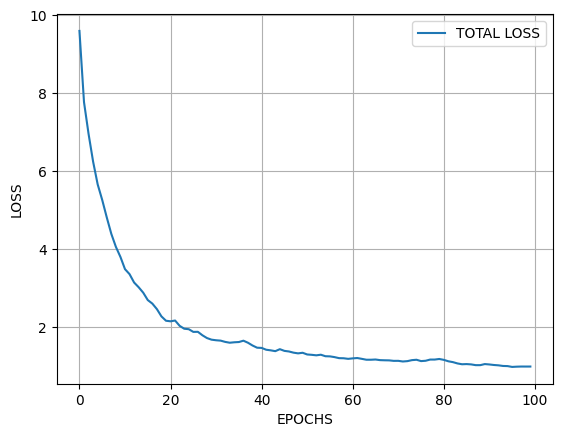

In [18]:
plt.plot(history.history['loss'], label='TOTAL LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.grid(True)
plt.show()


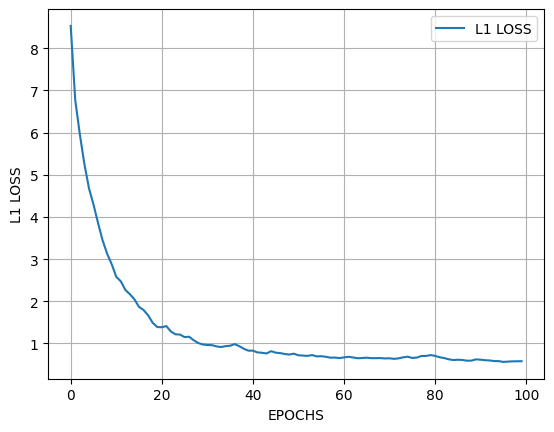

In [19]:
plt.plot(history.history['l1_norm_loss'], label='L1 LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('L1 LOSS')
plt.legend()
plt.grid(True)
plt.show()

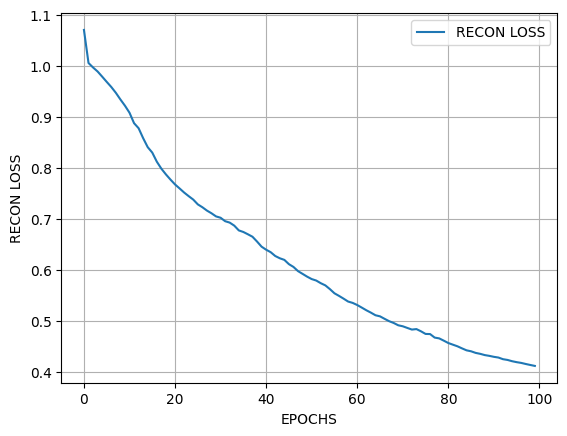

In [20]:
plt.plot(history.history['reconstruction_loss'], label='RECON LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('RECON LOSS')
plt.legend()
plt.grid(True)
plt.show()

# Analisis de las entropias

Uno de los objetivos al agregar una norma L1 como termino en la función de costo fue lograr que la reducción de dimensionalidad no fuera explicita, esto nos permite visualizar que columnas o dimensiones de nuestra base de datos son más o menos informativas, lo cual nos permite distinguir en cuales son más o menos útiles a considerar para el problema que estemos abordando.

En este caso estamos usando nuestro autocodificador en una base de datos de expresión génica para cancer de higado, que contiene aproximadamente 22000 columnas (genes), de las cuales no podriamos saber a simple vista cuales considerar para la clasificación de el tipo de cancer sin antes hacer por ejemplo un analisis de componentes principales, el entrenar una red neuronal como un autocodificador se presenta como una alternativa para obtener este tipo de resultados con un modelo de Deep Learning.

Para analizar que componentes aportan más o menos información nos valdremos de una cantidad llamada Entropía de la Información o Entropía de Shannon, en este analisis nos concentraremos primero en ver la entropia por dimensión, es decir, vamos a caracterizar cada gen con esta cantidad y a partir de esta veremos que columnas contienen más información relevante para la detección. De este modo los datos originales tendrán una entropia inicial y despues al pasar por el codificador nuestra red aprenderá una representación comprimida de los datos lo cual en principio deberia reducir la entropia de los mismos.

De los graficos se púede ver que efectivamente se ha logrado una reduccón de entropia en la representanción latente, esto quiere decir que nuestra red neuronal esta filtrando la información que es o no relevante para la clasificación, en este caso una columna (gen) con alta entropia tiene una expresión genica muy variada (distribución de probabilidad pareja) por lo que no aporta mucha información a la predicción mientras que  un gen que tiene baja entropia tiene una expresión genica más predecible por lo que su patron podria estar relacionado con el tipo de cancer (aporta más información a la clasificación), al reducirse esta entropia en el espacio latente estamos logrando que la red aprenda estos patrones relevantes en la información para los genes que los contienen.